In [4]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
# %matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import pvcircuit as pvc
from scipy import constants
from scipy.optimize import curve_fit, fsolve
from scipy.special import erfc
import itertools

from pvcircuit.physics_helpers import fit_sandia_simple
from pvlib.pvsystem import singlediode
import pvlib

import os
import sys

from glob import glob
from datetime import datetime, timedelta
import time
from tqdm.notebook import trange
import timeit
import pickle

# set path for NREL meteorological package and import
# sys.path.append("../../NREL_Meteorological")
from pvcircuit import EY,Spectra, Meteorological, sync
import warnings
from scipy.optimize import OptimizeWarning
import pickle
from scipy.interpolate import interp1d
from IPython.display import display, clear_output
from pvcircuit.EY2 import EnergyYield


In [18]:
dev3t = pvc.Tandem3T()
ey = EnergyYield(dev3t, 1.7)
# ey.load_meteo(pd.Timestamp(2021,11,1),pd.Timestamp(2021,11,11)-pd.Timedelta(seconds=1),'1T')con
ey.load_meteo(pd.Timestamp(2020,1,27),pd.Timestamp(2023,1,27)-pd.Timedelta(minutes=1),'1T')

Stored meteo data and spectra reloaded


Filter environmental data

In [17]:
ey.filter_meteo()

AttributeError: 'EnergyYield' object has no attribute 'meteo'

Load device parameters

In [11]:
if "notebook" in os.getcwd():
    path = os.path.join(os.path.dirname(os.getcwd()), "data")  # Data files here
else:
    path = os.path.join(os.getcwd(), "data")  # Data files here


datalist = glob(path + "**" + os.path.sep + "*")
# print(*(f"{i:>2} --> {os.path.basename(x)}" for i, x in enumerate(datalist)), sep="\n")

fp_psk_eqe = {
    1.25: [file for file in datalist if "1.25" in file and "_QE" in file][0],
    1.58: [file for file in datalist if "1.58eV_QE." in file and "_QE" in file][0],
    1.63: [file for file in datalist if "1.63" in file and "_QE" in file][0],
    1.68: [file for file in datalist if "1.68" in file and "_QE" in file][0],
    1.70: [file for file in datalist if "1.70" in file and "_QE" in file][0],
    1.75: [file for file in datalist if "1.75" in file and "_QE" in file][0],
    1.80: [file for file in datalist if "1.80" in file and "_QE" in file][0],
}

fp_psk_trans = {
    1.25: [file for file in datalist if "1.53" in file and "_tr" in file][0],
    1.58: [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.63: [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.68: [file for file in datalist if "1.63" in file and "_tr" in file][0],
    1.70: [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.75: [file for file in datalist if "1.70" in file and "_tr" in file][0],
    1.80: [file for file in datalist if "1.70" in file and "_tr" in file][0],
}

fp_psk_jv = {
    1.25: [file for file in datalist if "1.25" in file and "_JV" in file][0],
    # 1.58 : [file for file in datalist if "1.58eV_" in file and "_JV" in file][0],
    1.63: [file for file in datalist if "1.63" in file and "_JV" in file][0],
    1.68: [file for file in datalist if "1.68" in file and "_JV" in file][0],
    1.70: [file for file in datalist if "1.70" in file and "_JV" in file][0],
    1.75: [file for file in datalist if "1.75" in file and "_JV" in file][0],
    1.80: [file for file in datalist if "1.80" in file and "_JV" in file][0],
}


# file_psk_trans = "Pvsk0111D_1.7sb_tr.csv"
fp_si_eqe = {1.12: [file for file in datalist if "Si_101_E1_005_14_2B_postITO_QE.xlsx" in file][0]}
fp_si_jv = {1.12: [file for file in datalist if "Si_101_E1_005_14_2B_postITO_JV.csv" in file][0]}

In [12]:
ey.load_top_cell_diode_params(fp_psk_jv)
ey.load_top_cell_eqe(fp_psk_eqe)
ey.load_top_cell_transmittance(fp_psk_trans)
ey.load_bottom_cell_diode_params(fp_si_jv)
ey.load_bottom_cell_eqe(fp_si_eqe)
ey.make_mean_tandem()


/home/rwitteck/coding/pvc/.cenv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rwitteck/coding/pvc/.cenv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rwitteck/coding/pvc/.cenv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rwitteck/coding/pvc/.cenv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rwitteck/coding/pvc/.cenv/lib/python3.11/site-pack

### Prepare simulation
- Get the cell temperature
- Calculate temperautre dependent EQE and Eg
- Calculate current for top and bottom cell based on spectral input


In [13]:
ey.prepare_ey()
ey.cellEYeffMP()

/home/rwitteck/coding/pvc/.cenv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


running with 36 pools


Processing 2T:   0%|          | 0/1577269 [00:00<?, ?it/s]

/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/ea

Processing 3T:   0%|          | 0/1577269 [00:00<?, ?it/s]

/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/junction.py:373: RuntimeWarning: invalid value encountered in power
  return (self.Jdb * self.J0scale) ** (1.0 / self.n) * self.J0ratio / self.J0scale
/lustre/ea

Processing 4T:   0%|          | 0/1577269 [00:00<?, ?it/s]

/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/tandem3T.py:696: RuntimeWarning: invalid value encountered in scalar divide
  if (Pmpr - Pmpo) / Pmpr < tol:
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/tandem3T.py:696: RuntimeWarning: invalid value encountered in scalar divide
  if (Pmpr - Pmpo) / Pmpr < tol:
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/tandem3T.py:696: RuntimeWarning: invalid value encountered in scalar divide
  if (Pmpr - Pmpo) / Pmpr < tol:
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/tandem3T.py:696: RuntimeWarning: invalid value encountered in scalar divide
  if (Pmpr - Pmpo) / Pmpr < tol:
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/tandem3T.py:696: RuntimeWarning: invalid value encountered in scalar divide
  if (Pmpr - Pmpo) / Pmpr < tol:
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/tandem3T.py:696: RuntimeWarning: invalid value encountered in scalar divide
  if (Pmpr - Pmpo) / Pmpr < tol:
/lustre/eaglefs/scratch/rwitteck/pvc/pvcircuit/tandem3T.py:696: 

In [14]:
ey.bin_data(nr_of_ape_bins = 20, nr_of_temperature_bins = 5)
ey.run_ey_binning()

IndexError: index -1 is out of bounds for axis 0 with size 0

In [9]:
ey.binning_results

AttributeError: 'EnergyYield' object has no attribute 'binning_results'

AttributeError: 'EnergyYield' object has no attribute 'power_out'

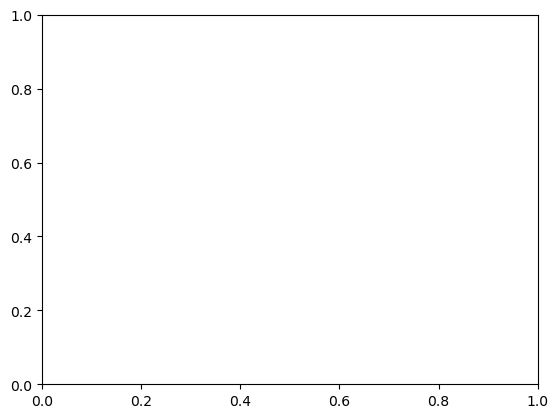

In [21]:
fig,ax = plt.subplots()
ax.plot(ey.irradiance,ey.power_out.div(ey.irradiance.values,axis=0)*1e6,".")

# ax.plot(ey.binning_results["BinPowerIn"],ey.binning_results["BinPower2T"]/ey.binning_results["BinPowerIn"]*1e6,"o")
# ax.plot(ey.binning_results["BinPowerIn"],ey.binning_results["BinPower3T"]/ey.binning_results["BinPowerIn"]*1e6,"o")
# ax.plot(ey.binning_results["BinPowerIn"],ey.binning_results["BinPower4T"]/ey.binning_results["BinPowerIn"]*1e6,"o")
# ax.plot(ey.binning_results["BinEnergy2T"][0] / ey.energy_out["2T"] - 1)
ax.legend(["2T","3T","4T","2Tbin","3Tbin","4Tbin"])


In [22]:
nr_of_ape_bins = [2,3,5,7,11,19,53,87,113,199,500,2000]
nr_of_temperature_bins = [1,2,3,4,5,20]

eta_binning = pd.DataFrame(np.zeros([len(nr_of_ape_bins) * len(nr_of_temperature_bins), 5]), columns=["ape_bins", "temp_bins", "eta2T","eta3T","eta4T"])

i = 0
eta_binning = pd.DataFrame(np.zeros([len(nr_of_ape_bins) * len(nr_of_temperature_bins), 5]), columns=["ape_bins", "temp_bins", "eta2T","eta3T","eta4T"])
for ape_bins in nr_of_ape_bins:
    for temp_bins in nr_of_temperature_bins:
        # run simulations
        ey.bin_data(nr_of_ape_bins = ape_bins, nr_of_temperature_bins = temp_bins)
        ey.run_ey_binning()
        
        #collect results
        eta_binning.loc[i,"ape_bins"] = ape_bins
        eta_binning.loc[i,"temp_bins"] = temp_bins
        eta_binning.loc[i,"eta2T"] = ey.binning_results["BinEnergy2T"][0] / ey.energy_out["2T"] - 1
        eta_binning.loc[i,"eta3T"] = ey.binning_results["BinEnergy3T"][0] / ey.energy_out["3T"] - 1
        eta_binning.loc[i,"eta4T"] = ey.binning_results["BinEnergy4T"][0] / ey.energy_out["4T"] - 1
        i+=1

        clear_output(wait=True)


IndexError: index -1 is out of bounds for axis 0 with size 0

NameError: name 'eta_binning' is not defined

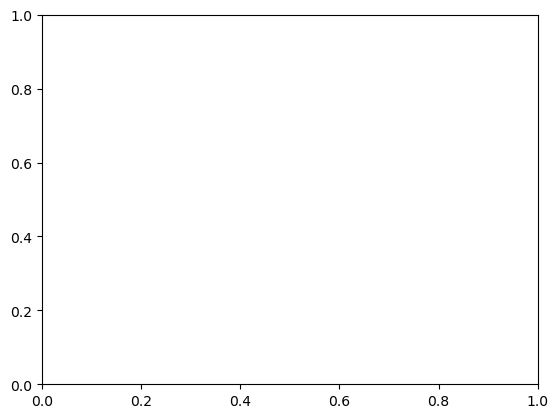

In [10]:
fig,ax = plt.subplots()

groups = eta_binning.groupby("temp_bins")

for gname,group in groups:
    # ax.plot(group["ape_bins"],group["eta2T"], "*", label = "$N_{{\mathrm{T}}}$="+f"{gname:g}")
    ax.plot(group["ape_bins"],group["eta4T"] * 100, ".", label = "$N_{{\mathrm{T}}}$="+f"{gname:g}")
    # ax.plot(nr_of_ape_bins,eta4T, "*", color=(1, 0, 0, 0.33), mfc=(1, 0, 0, 0.66), mec=(1, 0, 0))

# ax[1].set_title("Global irradiance")
ax.set_xlabel("Nr of APE bins")
ax.set_ylabel("Deviation bin vs full year [%]")
ax.set_box_aspect(1)
ax.set_ylim(bottom=0)
ax.legend(title="Temp bins", loc=9)